In [124]:
import numpy as np
from scipy import linalg
from scipy import optimize
import matplotlib.pyplot as plt
import math as math

In [125]:
# Set the font globally
plt.rcParams['font.family'] = 'serif'  # e.g., 'sans-serif', 'serif', 'monospace'
plt.rcParams['font.size'] = 12         # Set font size globally
plt.rcParams['mathtext.fontset'] = 'stix'  # For math text consistency with LaTeX
plt.rcParams['font.serif'] = ['Times New Roman']  # Use specific font

In [126]:
# dark mode
# plt.style.use('dark_background')

In [127]:
no_iter = 10 # Because of the factorial, this is the maximum number of iterations possible

In [128]:
# Defining constants
A_out = 201.4 # Wm^-2
B_out = 1.45 # Wm^-2C^-1
D = 0.3 # Wm^-2K^-1 For now. It is a tuning coefficient, so that we end up with a reasonable value of x_s
B = B_out/D
Q = 1360/4 # Wm^-2
S_2 = -0.477
a_u = 0.38 # if x > x_s
a_l = 0.68 # if x < x_s

In [129]:
# Legendre polynomials
P_0 = 1
P_0_deriv = 0
P_2 = lambda x: 0.5*(3*x**2 - 1)
P_2_deriv = lambda x: 3*x

In [130]:
def T_1(x):
    sum = 1
    for i in range(1, no_iter+1):
        numerator = 1
        denominator = 1
        for j in range(1, i+1):
            numerator *= (B + (2*j-1)*(2*j-2))
            #denominator *= 2*j
        sum += (numerator/math.factorial(2*j))*x**(2*i)
    return sum

def T_1_deriv(x):
    sum = 0
    for i in range(1, no_iter):
        numerator = 1
        denominator = 1
        for j in range(1, i+1):
            numerator *= (B + (2*j-1)*(2*j-2))
            # denominator *= (2*j - 1)
        sum += (numerator/math.factorial(2*j - 1))*x**(2*i-1)
    return sum

def T_3(x):
    sum = 1
    for i in range(1, no_iter):
        numerator = 1
        denominator = 1
        for j in range(1, i+1):
            numerator *= (B + j*(j-1))
            # denominator *= 2 * j**2
        sum += (numerator/math.factorial(2 * j**2))*(1-x)**i
    return sum

def T_3_deriv(x):
    sum = 0
    for i in range(1, no_iter):
        numerator = 1
        denominator = 1
        for j in range(1, i+1):
            numerator *= (B + j*(j-1))
            # denominator *= 2 * j**2
        sum += -i*(numerator/math.factorial(2 * j**2))*(1-x)**(i-1)
    return sum

In [131]:
def T_pu_min_T_pl(x):
    return (a_u-a_l)*P_0/B + S_2*(a_u-a_l)*P_2(x)/(6*B)

def T_pu_min_T_pl_deriv(x):
    return S_2*(a_u-a_l)*P_2_deriv(x)/(6*B)

In [132]:
# Now define the system of equations to be solved by linalg.solve
A = lambda x: np.array([[T_1(x), -T_3(x)], [T_1_deriv(x), -T_3_deriv(x)]])
b = lambda x: np.array([T_pu_min_T_pl(x), T_pu_min_T_pl_deriv(x)])

# Now solve the system for alpha and beta
x_s = 0.9
alpha0_del_Q, beta0_del_Q = linalg.solve(A(x_s), b(x_s))

In [133]:
# Solving for Q
def Q_func(x):
    return (A_out/B)/(beta0_del_Q*T_3(x) + (a_u/B)*(1+(S_2/6)))

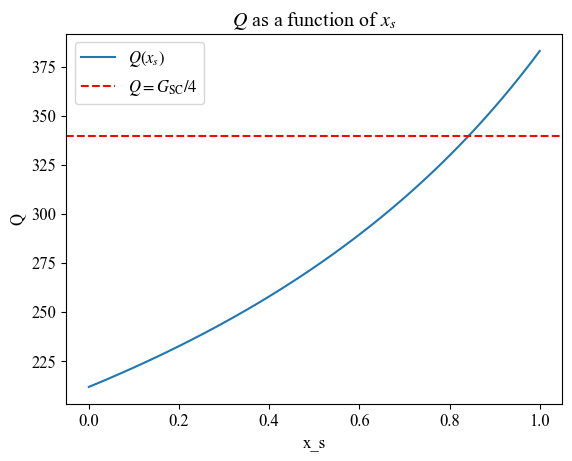

In [134]:
# Plotting Q
x_s_lst = np.linspace(0, 1, 100)
Q_lst = [Q_func(x) for x in x_s_lst]

plt.plot(x_s_lst, Q_lst, label=r'$Q(x_s)$')
plt.xlabel('x_s')
plt.ylabel('Q')
plt.axhline(y=Q, color='r', linestyle='--', label=r'$Q=G_{\text{SC}}/4$')
plt.yscale('linear')
plt.title(r'$Q$ as a function of $x_s$')
plt.legend()
plt.savefig('Q10_Q_as_func_of_x_s.png', dpi=300)
plt.show()

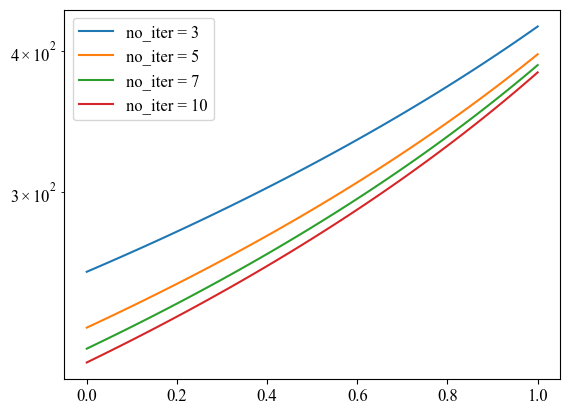

In [135]:
# Looking at the impact of number of iterations
no_iter_lst = [3, 5, 7, 10]
Q_lst_lst = []
for no_iter in no_iter_lst:
    A = lambda x: np.array([[T_1(x), -T_3(x)], [T_1_deriv(x), -T_3_deriv(x)]])
    b = lambda x: np.array([T_pu_min_T_pl(x), T_pu_min_T_pl_deriv(x)])
    alpha0_del_Q, beta0_del_Q = linalg.solve(A(x_s), b(x_s))
    Q_func = lambda x: (A_out/B)/(beta0_del_Q*T_3(x) + (a_u/B)*(1+(S_2/6)))
    Q_lst = [Q_func(x) for x in x_s_lst]
    Q_lst_lst.append(Q_lst)

for i in range(len(no_iter_lst)):
    plt.plot(x_s_lst, Q_lst_lst[i], label=f'no_iter = {no_iter_lst[i]}')
plt.legend()
plt.yscale('log')
plt.show()

In [136]:
def f(x, Q): # Function to find the root of
    return Q_func(x) - Q

def x_s_func(Q, x_0 = 0.5): # x_0 is initial guess
    soln = optimize.root(f, x_0, args=(Q))
    return soln["x"][0]

print("Computed x_s:", x_s_func(Q))

Computed x_s: 0.8425694115345446


### "Total" solution

In [137]:
def T_pu(x):
    return (Q*a_u-A_out)*P_0/B + Q*a_u*S_2*P_2(x)/(6*B) 

def T_pl(x):
    return (Q*a_l-A_out)*P_0/B + Q*a_l*S_2*P_2(x)/(6*B)

In [138]:
no_iter = 10
Q = 1360/4 # Wm^-2
x_s = x_s_func(Q)
print(x_s)
A = lambda x: np.array([[T_1(x), -T_3(x)], [T_1_deriv(x), -T_3_deriv(x)]])
b = lambda x: np.array([T_pu_min_T_pl(x), T_pu_min_T_pl_deriv(x)])
alpha0_del_Q, beta0_del_Q = linalg.solve(A(x_s), b(x_s))

0.8425694115345446


Min T: -16.562258470156845 Max T: 31.357778332001132


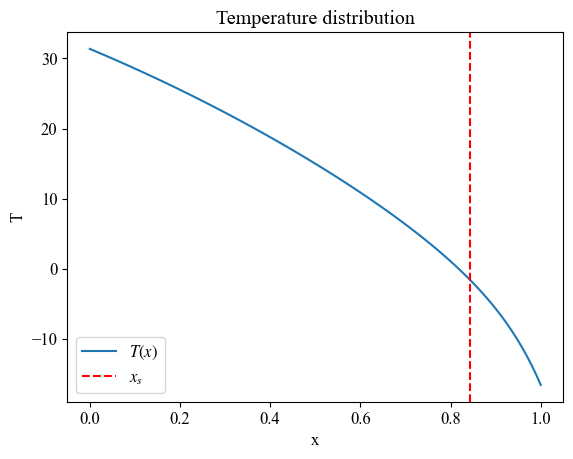

In [139]:
def T(x):
    return Q*alpha0_del_Q*T_1(x) + T_pl(x) + Q*beta0_del_Q*T_3(x) + T_pu(x)

x_lst = np.linspace(0, 1, 100)
T_lst = [T(x) for x in x_lst]
T_lst = np.array(T_lst)

print("Min T:", np.min(T_lst), "Max T:", np.max(T_lst))
plt.plot(x_lst, T_lst, label=r'$T(x)$')
plt.xlabel('x')
plt.ylabel('T')
plt.axvline(x=x_s, color='r', linestyle='--', label=r'$x_s$')
plt.title('Temperature distribution')
plt.legend()
plt.savefig('Q10_temp_distribution.png', dpi=300)
plt.show()